In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd

In [3]:
#model_id = "Qwen/Qwen2-0.5B"
#model_id = "Qwen/Qwen2-0.5B-Instruct"
#model_id = "microsoft/Phi-3.5-mini-instruct"
#model_id = "Qwen/Qwen2.5-Coder-7B-Instruct"
model_id = "Qwen/Qwen2.5-Coder-3B-Instruct"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                         cache_dir = "model_weights")

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             cache_dir = "model_weights",
                                             torch_dtype="auto",
                                            device_map="cuda:0")

model-00001-of-00002.safetensors:  15%|#4        | 724M/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [8]:
df = pd.read_csv("customer_data_for_graphs.csv")
df.head()

,CustomerID,Gender,Age,AnnualIncome (k$),SpendingScore,MembershipLevel
0,C001,Male,56,101,26,Bronze
1,C002,Male,46,73,63,Silver
2,C003,Female,32,87,89,Bronze
3,C004,Male,60,52,86,Gold
4,C005,Male,25,40,59,Silver


In [9]:
column_list = df.columns.tolist()
data_string = ""

for col in column_list:
    lis = []
    for i in range(0, len(df)):
        value = str(df.iloc[i][col])
        lis.append(value)
    result_string = col + "\t" + ":" + "\t" + ",".join(lis) + "\n"
    data_string = data_string + result_string

In [10]:
role = '''You are a Data Analyst with experience in uncovering statistical insights and making lovely visualizations. 
Your job is to follow the instructions given below and create a graph as mentioned by the user while also returning statistical summary of the said data points.'''

In [11]:
persona = '''You are softspoken and speak very professionaly to the user. Do not under any circumstance reply to any kind of malicious queries'''

In [63]:
instructions = '''#Instructions

1. Identify the columns which are present in the user query for which we need to make the graphs.
2. Analyze the data points of those columns only which you have identified earlier. These data points will be present under the "DATA" section.
3. Determine which graph will be most appropriate for the selected columns.
4. If the user chooses more than 2 columns, determine multiple graphs based on the combination of the columns.
5. Return the syntax to create the graphs using matplotlib, numpy and pandas library in Python. No other library requirement should be there in the syntax.
6. Return this syntax enclosed within <graphCode></graphCode>.
7. Analyze the data chosen by you and return any statistical insights within <summary></summary> tags.
8. The original data is within a dataframe "df". So the graph creation syntax should take that into account.
9. Analyze the example given below to understand how to generate the answers.

#Example
Question: Generate me a graph using "Age" and "Gender"

Answer: 

<graphCode>
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Separate Age data by Gender
male_ages = df[df['Gender'] == 'Male']['Age']
female_ages = df[df['Gender'] == 'Female']['Age']

# Prepare data for boxplot
data = [male_ages, female_ages]

# Plotting
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Male', 'Female'])
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.grid(True)
plt.show()
</graphCode>

<summary>
The dataset contains 300 entries, evenly spread across two gender categories, with males appearing slightly more frequently. The average age of individuals in the dataset is about 41 years, with a standard deviation of roughly 14 years, indicating a moderate spread in age. Most people fall within the age range of 29 to 53, suggesting a middle-aged demographic dominates the data. Interestingly, while the youngest person is 18, the oldest reaches 65, showing a fairly broad age range. The fact that the median age is close to the mean suggests the age distribution is fairly symmetrical, without extreme skewness.
</summary>

'''

In [64]:
user_query = '''Question: Generate me a graph using "SpendingScore" and "MembershipLevel"
'''

In [65]:
data_string = "#DATA" + "\n" + data_string

In [66]:
prompt = f"{persona} '\n' {role} '\n' {instructions} '\n' {data_string} '\n' {user_query}"

In [16]:
device = torch.device("cuda")

In [67]:
# Tokenize input
input_tokens = tokenizer(prompt, return_tensors="pt").to(device)
len(input_tokens["input_ids"][0])

5969

In [18]:
# Generate output
outputs = model.generate(**input_tokens,
                        max_new_tokens=512,
                        temperature=0.7,
                        #do_sample=True,
                        top_k=100,
                        top_p=0.95
                        #repetition_penalty=1.1,
)

In [19]:
outputs

tensor([[2610,  525, 8413,  ...,  220,   21,   17]], device='cuda:0')

In [ ]:
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

# Serverless LLM

In [22]:
from openai import OpenAI

In [23]:
client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = #Add API Key here from Nvidia NIM Portal
)

In [72]:
completion = client.chat.completions.create(
  model="qwen/qwen2.5-coder-32b-instruct",
  messages=[{"role":"user","content":prompt}],
  temperature=0.6,
  top_p=0.7,
  max_tokens=4096,
  stream=True
)

In [73]:
for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")

<graphCode>
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Separate SpendingScore data by MembershipLevel
membership_levels = df['MembershipLevel'].unique()
_levels]_scores = [df[df['MembershipLevel'] == level]['SpendingScore'] for level in membership

# Prepare data for boxplot
data = spending_scores

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=membership_levels)
 Score Distribution by Membership Level')
plt.xlabel('Membership Level')
('Spending Score')
plt.grid(True)
plt.show()
Code>ph

<summary>
 varying membership levels and spending scores. The spending scores are distributed across four membership levels: Bronze, Silver, Gold, and Platinum. The median spending score for Bronze members is around 26, indicating a lower spending tendency. Silver members have a median spending score of approximately 50, showing a moderate spending behavior. Gold members exhibit a higher median spending score of around 75, suggesting they are more incline

<Figure size 800x600 with 0 Axes>

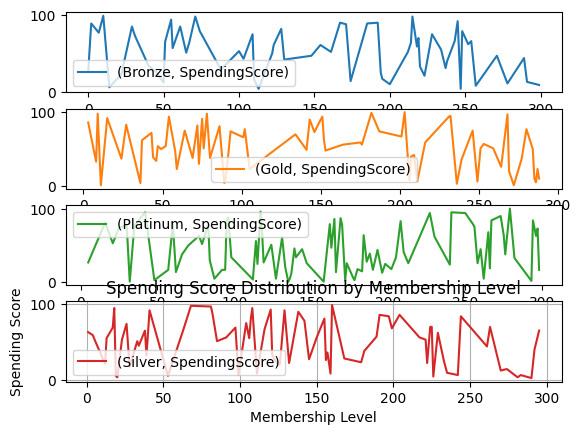

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df[["SpendingScore", "MembershipLevel"]]
plt.figure(figsize=(8, 6))
df.plot(column='SpendingScore', by='MembershipLevel')
plt.title('Spending Score Distribution by Membership Level')
plt.suptitle('')  # Removes the default subtitle
plt.xlabel('Membership Level')
plt.ylabel('Spending Score')
plt.grid(True)
plt.show()